In [2]:
# ! pip install pycaret --use-pep517
# ! pip install xgboost
# !pip install shap-selection
# !pip install fitter
# !pip install plotnine

In [3]:
# Imports generales

import io
import pandas as pd
import numpy as np
# import holidays
from datetime import timedelta
from numpy import corrcoef, transpose, arange
import plotly.express as px
import boto3
from io import BytesIO
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from fitter import Fitter
from scipy.stats import beta
from scipy import stats

from pycaret import clustering
from pycaret.clustering import *

from scipy.stats import chi2_contingency

from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering
from sklearn.mixture._gaussian_mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score, classification_report 
# import plotnine as p9

from mpl_toolkits.mplot3d import Axes3D

Matplotlib is building the font cache; this may take a moment.


# Cargar el dataset

In [13]:
# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
s3_file_key  = 'modelos/model_df_exp2.csv'

# Descargar el archivo en memoria
response = s3.get_object(Bucket=bucket_name, Key=s3_file_key)
file_stream = BytesIO(response['Body'].read())

# Leer el archivo en un DataFrame de pandas
df = pd.read_csv(file_stream)  # Usa read_csv(file_stream) si es CSV


In [14]:
# Preprocess_df = pd.read_csv('data/model_df_exp2.csv')

# Análisis de features importance

In [15]:
Preprocess_df = df.copy()

In [16]:
Preprocess_df.columns

Index(['Municipio', 'Clasifiación casos municipio',
       'Cobertura servicios básicos departamento', 'DestinoUsuario', 'Edad',
       'Sexo', 'ZonaResidencia', 'Prestador:1.publica/0.privada', 'Año',
       'HoraIngreso', 'HoraSalida', 'TiempoDeEstancia horas',
       'Es festivo (S/N)', 'Es víspera (S/N)', 'Día Laborable',
       'Día de la semana', 'Día del mes', 'Es fin de semana',
       'Clasificación estancia', 'Grupo etario', 'ClasificaciónSalidaCrítica',
       'Tipo Prestador_CLINICA', 'Tipo Prestador_HOSPITAL',
       'Tipo Prestador_IPS', 'Tipo Prestador_OTRA',
       'Clasificación casos municipio_int', 'Region_departamento_Amazonica',
       'Region_departamento_Andina', 'Region_departamento_Caribe',
       'Region_departamento_Orinoquía', 'Region_departamento_Pacifica',
       'Cobertura servicios básicos departamento_int', 'Sexo_int_F0_M1',
       'ZonaResidencia_int_U0-R1', 'CausaExternaNueva_Accidente de trabajo',
       'CausaExternaNueva_Accidente de tránsito',
   

In [17]:
# Identificar variables categóricas
categorical_vars = Preprocess_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identificar variables numéricas
numerical_vars = Preprocess_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Mostrar las listas
print("Variables Categóricas:", categorical_vars)
print("Variables Numéricas:", numerical_vars)

Variables Categóricas: ['Municipio', 'Clasifiación casos municipio', 'Cobertura servicios básicos departamento', 'Sexo', 'ZonaResidencia', 'Es festivo (S/N)', 'Es víspera (S/N)', 'Día Laborable', 'Día de la semana', 'Es fin de semana', 'Clasificación estancia', 'Grupo etario', 'ClasificaciónSalidaCrítica']
Variables Numéricas: ['DestinoUsuario', 'Edad', 'Prestador:1.publica/0.privada', 'Año', 'HoraIngreso', 'HoraSalida', 'TiempoDeEstancia horas', 'Día del mes', 'Tipo Prestador_CLINICA', 'Tipo Prestador_HOSPITAL', 'Tipo Prestador_IPS', 'Tipo Prestador_OTRA', 'Clasificación casos municipio_int', 'Region_departamento_Amazonica', 'Region_departamento_Andina', 'Region_departamento_Caribe', 'Region_departamento_Orinoquía', 'Region_departamento_Pacifica', 'Cobertura servicios básicos departamento_int', 'Sexo_int_F0_M1', 'ZonaResidencia_int_U0-R1', 'CausaExternaNueva_Accidente de trabajo', 'CausaExternaNueva_Accidente de tránsito', 'CausaExternaNueva_Enfermedad general', 'CausaExternaNueva_Enf

In [18]:
balanced_df = Preprocess_df[['Municipio', 'DestinoUsuario', 'Edad', 'Prestador:1.publica/0.privada', 'Año', 
               'HoraIngreso', 'HoraSalida', 'TiempoDeEstancia horas', 'Día del mes', 'Tipo Prestador_CLINICA', 
               'Tipo Prestador_HOSPITAL', 'Tipo Prestador_IPS', 'Tipo Prestador_OTRA', 'Clasificación casos municipio_int', 
               'Region_departamento_Amazonica', 'Region_departamento_Andina', 'Region_departamento_Caribe', 
               'Region_departamento_Orinoquía', 'Region_departamento_Pacifica', 'Cobertura servicios básicos departamento_int', 
               'Sexo_int_F0_M1', 'ZonaResidencia_int_U0-R1', 'CausaExternaNueva_Accidente de trabajo', 
               'CausaExternaNueva_Accidente de tránsito', 'CausaExternaNueva_Enfermedad general', 'CausaExternaNueva_Enfermedad laboral', 
               'CausaExternaNueva_Mordeduras y picaduras de animales', 'CausaExternaNueva_Otros accidentes', 
               'CausaExternaNueva_Violencia y maltrato', 'Clasificación aseguradora_ARL', 'Clasificación aseguradora_Compañía de Seguros', 
               'Clasificación aseguradora_EPS', 'Clasificación aseguradora_Medicina Prepagada', 'Clasificación aseguradora_Otras Instituciones de Salud', 
               'TipoUsuario_nuevo_Otro', 'TipoUsuario_nuevo_Régimen Contributivo', 'TipoUsuario_nuevo_Régimen Subsidiado', 
               'TipoUsuario_nuevo_Victima (Contributivo/Subsidiado/No Asegurado)', 'TipoUsuario_nuevo_Vinculado/particular', 
               'Es festivo (S1/N0)', 'Es víspera (S1/N0)', 'Día Laborable S1 N0', 'Día de la semana_int', 'Mes_sin', 'Mes_cos',
               'Rango_horario_sin', 'Rango_horario_cos', 'Rango_horario_salida_sin', 'Rango_horario_salida_cos', 
               'Es_fin_de_semana_bin S1 N0', 'Clasificación_estancia_int C0 M1', 'Grupo_etario_int', 'ClasificaciónSalidaCrítica_bin S1 N0',
               'ReClasificaciónSalida_Infecciones', 'ReClasificaciónSalida_Otros Motivos o No Especificados',
               'ReClasificaciónSalida_Síntomas Generales y Varios', 'ReClasificaciónSalida_Trastornos Crónicos o No Infecciosos', 
               'ReClasificaciónSalida_Traumatismos y Lesiones']]

In [19]:
# Identificar variables categóricas
categorical_vars = balanced_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identificar variables numéricas
numerical_vars = balanced_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Mostrar las listas
print("Variables Categóricas:", categorical_vars)
print("Variables Numéricas:", numerical_vars)

Variables Categóricas: ['Municipio']
Variables Numéricas: ['DestinoUsuario', 'Edad', 'Prestador:1.publica/0.privada', 'Año', 'HoraIngreso', 'HoraSalida', 'TiempoDeEstancia horas', 'Día del mes', 'Tipo Prestador_CLINICA', 'Tipo Prestador_HOSPITAL', 'Tipo Prestador_IPS', 'Tipo Prestador_OTRA', 'Clasificación casos municipio_int', 'Region_departamento_Amazonica', 'Region_departamento_Andina', 'Region_departamento_Caribe', 'Region_departamento_Orinoquía', 'Region_departamento_Pacifica', 'Cobertura servicios básicos departamento_int', 'Sexo_int_F0_M1', 'ZonaResidencia_int_U0-R1', 'CausaExternaNueva_Accidente de trabajo', 'CausaExternaNueva_Accidente de tránsito', 'CausaExternaNueva_Enfermedad general', 'CausaExternaNueva_Enfermedad laboral', 'CausaExternaNueva_Mordeduras y picaduras de animales', 'CausaExternaNueva_Otros accidentes', 'CausaExternaNueva_Violencia y maltrato', 'Clasificación aseguradora_ARL', 'Clasificación aseguradora_Compañía de Seguros', 'Clasificación aseguradora_EPS', 'C

In [20]:
Preprocess_df.Municipio.value_counts()

Municipio
MEDELLIN                           1285704
BELLO                                72040
ENVIGADO                             37743
ITAGUI                               35747
SABANETA                             13898
                                    ...   
PEDRAZA                                  1
SANTANA                                  1
CHIVOLO                                  1
SAN JOSE DE MIRANDA                      1
SANTAFE DE BOGOTA D.C.-ENGATIVA          1
Name: count, Length: 657, dtype: int64

In [21]:
balanced_df.DestinoUsuario.value_counts()

DestinoUsuario
1    1192017
3     356183
2       9074
Name: count, dtype: int64

In [22]:
# Paso 1: Filtrar Medellín y demás municipios
df_medellin = balanced_df[balanced_df['Municipio'] == 'MEDELLIN']
df_otros = balanced_df[balanced_df['Municipio'] != 'MEDELLIN']

X_medellin = df_medellin.drop(columns=['Municipio', 'DestinoUsuario'])

In [23]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Ver distribución original de DestinoUsuario en Medellín
print("Distribución original de DestinoUsuario en Medellín:", Counter(df_medellin['DestinoUsuario']))

# Definir estrategia de submuestreo: distribución proporcional
total_medellin = 80000  # Número total de instancias deseadas
distribucion_original = Counter(df_medellin['DestinoUsuario'])
sampling_strategy = {clase: int((distribucion_original[clase] / sum(distribucion_original.values())) * total_medellin) 
                     for clase in distribucion_original}

# Aplicar Random Undersampling con estrategia multiclase
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_medellin.drop(columns=['Municipio', 'DestinoUsuario']), df_medellin['DestinoUsuario'])

# Convertir de nuevo a DataFrame
df_medellin_resampled = pd.DataFrame(X_resampled, columns=X_medellin.columns)
df_medellin_resampled['Municipio'] = 'MEDELLIN'
df_medellin_resampled['DestinoUsuario'] = y_resampled

# Combinar con los demás municipios
df_balanced_2 = pd.concat([df_medellin_resampled, df_otros], ignore_index=True)

# Ver distribución final en Medellín
print("Distribución después de RUS en Medellín:", Counter(df_balanced_2[df_balanced_2['Municipio'] == 'MEDELLIN']['DestinoUsuario']))



Distribución original de DestinoUsuario en Medellín: Counter({1: 1021009, 3: 256951, 2: 7744})
Distribución después de RUS en Medellín: Counter({1: 63529, 3: 15988, 2: 481})


In [ ]:
df_balanced_2.to_csv('df_balanced_2.csv', index = False)

In [ ]:
df_balanced_2 = pd.read_csv('df_balanced_2.csv')

In [ ]:
df_balanced_2.shape

In [25]:
# Obtener la distribución original de DestinoUsuario en Medellín
from collections import Counter
distribucion_original = Counter(df_medellin['DestinoUsuario'])

# Definir la cantidad total deseada (80,000 instancias)
total_medellin = 80000

# Calcular la cantidad de instancias a retener por clase, pero sin tocar la clase 2
sampling_strategy = {}
for clase, cantidad in distribucion_original.items():
    if clase == 2:  # No modificar la clase 2
        sampling_strategy[clase] = cantidad
    else:  # Reducir proporcionalmente las demás clases
        sampling_strategy[clase] = int((cantidad / (sum(distribucion_original.values()) - distribucion_original[2])) * (total_medellin - distribucion_original[2]))

# Aplicar Random Undersampling sin tocar la clase 2
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(df_medellin.drop(columns=['Municipio', 'DestinoUsuario']), df_medellin['DestinoUsuario'])

# Convertir de nuevo a DataFrame
df_medellin_resampled = pd.DataFrame(X_resampled, columns=X_medellin.columns)
df_medellin_resampled['Municipio'] = 'MEDELLIN'
df_medellin_resampled['DestinoUsuario'] = y_resampled

# Combinar con los demás municipios
df_balanced_3 = pd.concat([df_medellin_resampled, df_otros], ignore_index=True)

# Ver distribución final en Medellín
print("Distribución después de RUS en Medellín:", Counter(df_balanced_3[df_balanced_3['Municipio'] == 'MEDELLIN']['DestinoUsuario']))


Distribución después de RUS en Medellín: Counter({1: 57727, 3: 14528, 2: 7744})


In [78]:
df_balanced_3.to_csv('df_balanced_3.csv')

# Análisis de variables importantes RandomForest

## RandomForest 1

In [ ]:
df_balanced_2 = df_balanced_2.drop('Municipio', axis=1)

In [ ]:
# Dividir en conjunto de entrenamiento y prueba
X = df_balanced_2.drop('DestinoUsuario', axis=1)
y = df_balanced_2['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

In [26]:
df_balanced_3 = df_balanced_3.drop('Municipio', axis=1)

# Dividir en conjunto de entrenamiento y prueba
X = df_balanced_3.drop('DestinoUsuario', axis=1)
y = df_balanced_3['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.82
              precision    recall  f1-score   support

           1       0.84      0.91      0.87     45947
           2       0.81      0.19      0.31      1740
           3       0.78      0.69      0.73     22627

    accuracy                           0.82     70314
   macro avg       0.81      0.60      0.64     70314
weighted avg       0.82      0.82      0.81     70314



## RandomForest 2

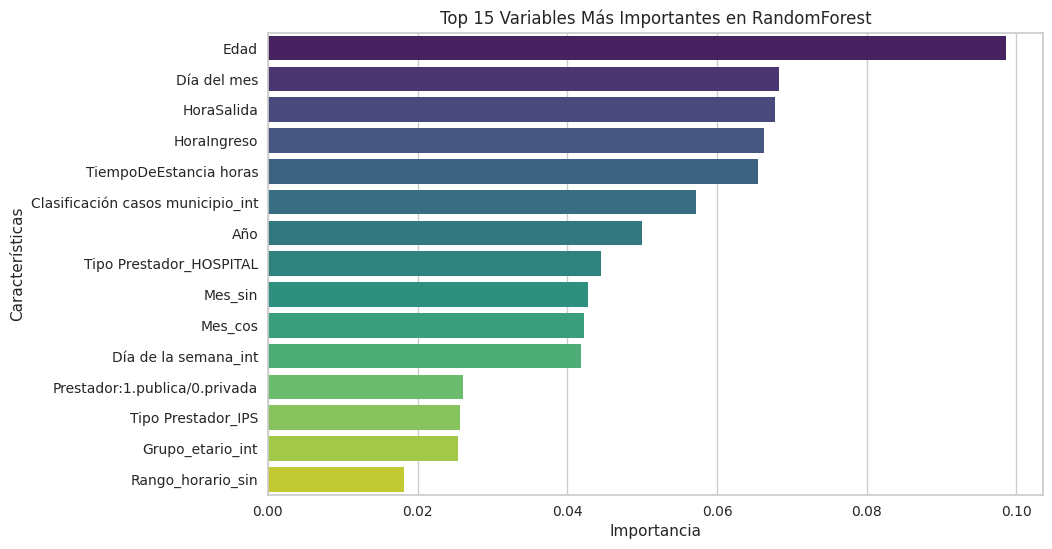

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
plt.rcParams['font.family'] = 'DejaVu Sans'  # O usa cualquier otra fuente disponible en tu entorno

# Dividir en conjunto de entrenamiento y prueba
X = df_balanced_3.drop('DestinoUsuario', axis=1)
y = df_balanced_3['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo nuevamente
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar las variables más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette="viridis")
plt.title("Top 15 Variables Más Importantes en RandomForest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()


In [ ]:
# Calcular la importancia acumulada
importance_df['Cumulative Importance'] = importance_df['Importance'].cumsum()

importance_df



In [ ]:
list(importance_df.Feature)

In [27]:
importance_df_selected = df_balanced_3[['DestinoUsuario','Edad',
 'Día del mes',
 # 'HoraSalida',
 'HoraIngreso',
 # 'TiempoDeEstancia horas',
 'Clasificación casos municipio_int',
 'Año',
 'Tipo Prestador_HOSPITAL',
 'Mes_sin',
 'Mes_cos',
 'Día de la semana_int',
 'Prestador:1.publica/0.privada',
 'Tipo Prestador_IPS',
 'Grupo_etario_int',
 'Rango_horario_sin',
 # 'Rango_horario_salida_sin',
 # 'Rango_horario_salida_cos',
 'Rango_horario_cos',
 'Tipo Prestador_CLINICA',
 'CausaExternaNueva_Enfermedad general',
 'CausaExternaNueva_Otros accidentes',
 'CausaExternaNueva_Accidente de tránsito',
 'CausaExternaNueva_Violencia y maltrato',
 'CausaExternaNueva_Accidente de trabajo',
 'CausaExternaNueva_Mordeduras y picaduras de animales',
 'CausaExternaNueva_Enfermedad laboral']]

In [28]:
# Dividir en conjunto de entrenamiento y prueba
X = importance_df_selected.drop('DestinoUsuario', axis=1)
y = importance_df_selected['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.77
              precision    recall  f1-score   support

           1       0.80      0.87      0.84     45947
           2       0.67      0.32      0.43      1740
           3       0.70      0.60      0.65     22627

    accuracy                           0.77     70314
   macro avg       0.73      0.60      0.64     70314
weighted avg       0.77      0.77      0.77     70314



In [29]:
# Dividir en conjunto de entrenamiento y prueba
X = importance_df_selected.drop('DestinoUsuario', axis=1)
y = importance_df_selected['DestinoUsuario']

### Balanceo 

In [42]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN(random_state=123).fit_resample(X, y)

In [44]:
len(y_resampled)

672853

In [45]:
X_resampled.to_csv('X_resampled_2.csv',index=False)
y_resampled.to_csv('y_resampled_2.csv',index=False)

In [47]:
X_resampled = pd.read_csv('X_resampled_2.csv')
y_resampled = pd.read_csv('y_resampled_2.csv')

In [48]:
y_resampled.value_counts()

DestinoUsuario
1                 228735
2                 227854
3                 216264
Name: count, dtype: int64

### MODELO 1

In [53]:
# Dividir en conjunto de entrenamiento y prueba
# X = importance_df_selected.drop('DestinoUsuario', axis=1)
# y = importance_df_selected['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
RandomModel = RandomForestClassifier(random_state=42)
RandomModel.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = RandomModel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.86
              precision    recall  f1-score   support

           1       0.82      0.84      0.83     45826
           2       0.94      0.98      0.96     45556
           3       0.82      0.77      0.79     43189

    accuracy                           0.86    134571
   macro avg       0.86      0.86      0.86    134571
weighted avg       0.86      0.86      0.86    134571



In [54]:
print(RandomModel.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = RandomModel.predict(X_train)
y_train_prob = RandomModel.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = RandomModel.predict(X_test)
y_test_prob = RandomModel.predict_proba(X_test)

In [56]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9986
Precision (macro): 0.9986
Recall (macro): 0.9986
F1 Score (macro): 0.9986
AUC (One-vs-Rest): 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    182909
           2       1.00      1.00      1.00    182298
           3       1.00      1.00      1.00    173075

    accuracy                           1.00    538282
   macro avg       1.00      1.00      1.00    538282
weighted avg       1.00      1.00      1.00    538282

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8612
Precision (macro): 0.8589
Recall (macro): 0.8597
F1 Score (macro): 0.8589
AUC (One-vs-Rest): 0.9613
              precision    recall  f1-score   support

           1       0.82      0.84      0.83     45826
           2       0.94      0.98      0.96     45556
           3       0.82      0.77      0.79     43189

    accuracy                       

### MODELO 2

In [61]:
# Dividir en conjunto de entrenamiento y prueba
# X = importance_df_selected.drop('DestinoUsuario', axis=1)
# y = importance_df_selected['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


RandomModel2 = RandomForestClassifier(n_estimators = 50, random_state=42,
                                     max_depth=None,          # Evita árboles demasiado profundos
                                     min_samples_split=2,  # Evita divisiones innecesarias
                                     min_samples_leaf=1,    # No permite hojas con muy pocos datos
                                     max_features='log2',   # Reduce especialización en cada árbol # Para manejar clases desbalanceadas
                                     bootstrap=True,        # Usa muestreo con reemplazo para mayor variabilidad
                                     n_jobs=-1,             # Usa todos los núcleos de CPU
                                     )


# Entrenar el modelo
RandomModel2.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = RandomModel2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.86
              precision    recall  f1-score   support

           1       0.82      0.84      0.83     45826
           2       0.94      0.98      0.96     45556
           3       0.82      0.76      0.79     43189

    accuracy                           0.86    134571
   macro avg       0.86      0.86      0.86    134571
weighted avg       0.86      0.86      0.86    134571



### Modelo 3

In [59]:
type(y_train )

pandas.core.frame.DataFrame

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles
    'max_depth': [10, 20, 30, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimas muestras en una hoja
    'max_features': ['sqrt', 'log2', None],  # Máximo de features consideradas
    'bootstrap': [True, False]  # Si se usa bootstrap para muestreo
}

# Inicializar el modelo
rf = RandomForestClassifier(random_state=42)

# Configurar la búsqueda aleatoria
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
rf_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", rf_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

# Importar métricas
from sklearn.metrics import classification_report, accuracy_score

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=10.3min
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 5.6min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.7min
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 5.5min
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 5.6min
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=10.3min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = best_rf.predict(X_train)
y_train_prob = best_rf.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)

In [65]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9427
Precision (macro): 0.9431
Recall (macro): 0.9418
F1 Score (macro): 0.9420
AUC (One-vs-Rest): 0.9942
              precision    recall  f1-score   support

           1       0.91      0.95      0.93    182909
           2       0.97      0.99      0.98    182298
           3       0.95      0.89      0.92    173075

    accuracy                           0.94    538282
   macro avg       0.94      0.94      0.94    538282
weighted avg       0.94      0.94      0.94    538282

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8533
Precision (macro): 0.8510
Recall (macro): 0.8514
F1 Score (macro): 0.8502
AUC (One-vs-Rest): 0.9571
              precision    recall  f1-score   support

           1       0.81      0.84      0.83     45826
           2       0.92      0.97      0.95     45556
           3       0.82      0.74      0.78     43189

    accuracy                       

In [67]:
import pickle
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(best_rf, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/best_rf_05_02.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/best_rf_05_02.pkl


In [68]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


Modelo entrenado con importance_df_selected

## ModeloLGBMClassifier

In [76]:
# import lightgbm as lgb
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import classification_report, accuracy_score

# Limpiar los nombres de las columnas (reemplazar caracteres no válidos por guiones bajos)
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)

# Ahora intenta volver a ejecutar el modelo
lgbm_random.fit(X_train, y_train)


# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'num_leaves': [10, 20, 30, 40, 50],  # Controla la complejidad del árbol
    'max_depth': [5, 10, 15, 20, None],  # Profundidad máxima
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasa de aprendizaje (regularización)
    'n_estimators': [100, 200, 500],  # Número de árboles
    'min_child_samples': [10, 20, 30],  # Regularización: mínimo de muestras en nodos hoja
    'subsample': [0.6, 0.8, 1.0],  # Porcentaje de datos usados en cada árbol (regularización)
    'colsample_bytree': [0.6, 0.8, 1.0],  # Porcentaje de features usadas en cada árbol
    'lambda_l1': [0.0, 0.1, 1.0],  # Regularización L1 (Lasso)
    'lambda_l2': [0.0, 0.1, 1.0]   # Regularización L2 (Ridge)
}

# Inicializar el modelo
lgbm = lgb.LGBMClassifier(random_state=42)

# Configurar la búsqueda aleatoria
lgbm_random = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
lgbm_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", lgbm_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_lgbm = lgbm_random.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [72]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = best_lgbm.predict(X_train)
y_train_prob = best_lgbm.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = best_lgbm.predict(X_test)
y_test_prob = best_lgbm.predict_proba(X_test)

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


In [73]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.7914
Precision (macro): 0.7917
Recall (macro): 0.7888
F1 Score (macro): 0.7870
AUC (One-vs-Rest): 0.9286
              precision    recall  f1-score   support

           1       0.74      0.84      0.79    182909
           2       0.85      0.88      0.87    182298
           3       0.78      0.64      0.70    173075

    accuracy                           0.79    538282
   macro avg       0.79      0.79      0.79    538282
weighted avg       0.79      0.79      0.79    538282

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.7871
Precision (macro): 0.7868
Recall (macro): 0.7843
F1 Score (macro): 0.7824
AUC (One-vs-Rest): 0.9253
              precision    recall  f1-score   support

           1       0.74      0.84      0.79     45826
           2       0.85      0.88      0.86     45556
           3       0.77      0.63      0.69     43189

    accuracy                       

In [74]:
import pickle
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(best_lgbm, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/best_lgbm_05_02.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/best_lgbm_05_02.pkl


In [75]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


Modelo entrenado con importance_df_selected

In [82]:
# import numpy as np
# from deap import base, creator, tools, algorithms
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import accuracy_score

# # Dividir en conjunto de entrenamiento y prueba
# X = df_balanced_3.drop('DestinoUsuario', axis=1)
# y = df_balanced_3['DestinoUsuario']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Crear un espacio para los hiperparámetros
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMax)

# # Función para inicializar individuos con valores aleatorios
# def create_individual():
#     return [
#         np.random.randint(10, 100),   # num_leaves
#         np.random.randint(3, 15),     # max_depth
#         np.random.choice([0.01, 0.05, 0.1, 0.2]),  # learning_rate
#         np.random.randint(100, 1000), # n_estimators
#         np.random.randint(10, 100),   # min_child_samples
#         np.random.choice([0.6, 0.8, 1.0]), # subsample
#         np.random.choice([0.6, 0.8, 1.0]), # colsample_bytree
#         np.random.choice([0.0, 0.1, 1.0]),   # lambda_l1
#         np.random.choice([0.0, 0.1, 1.0])    # lambda_l2
#     ]

# # Función de evaluación
# def evaluate(individual):
#     # Definir los hiperparámetros de LightGBM a partir del individuo
#     params = {
#         'num_leaves': individual[0],
#         'max_depth': individual[1],
#         'learning_rate': individual[2],
#         'n_estimators': individual[3],
#         'min_child_samples': individual[4],
#         'subsample': individual[5],
#         'colsample_bytree': individual[6],
#         'lambda_l1': individual[7],
#         'lambda_l2': individual[8],
#         'random_state': 42
#     }
    
#     # Entrenar el modelo y calcular el score
#     model = lgb.LGBMClassifier(**params)
#     score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    
#     return score,

# # Configurar el algoritmo genético
# toolbox = base.Toolbox()
# toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
# toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("evaluate", evaluate)

# # Crear la población
# population = toolbox.population(n=10)  # 10 individuos

# # Algoritmo evolutivo
# algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=5, verbose=True)

# # Evaluar el mejor individuo
# best_individual = tools.selBest(population, 1)[0]
# print("Mejores hiperparámetros encontrados:", best_individual)

# # Entrenar el modelo con los mejores hiperparámetros
# params = {
#     'num_leaves': best_individual[0],
#     'max_depth': best_individual[1],
#     'learning_rate': best_individual[2],
#     'n_estimators': best_individual[3],
#     'min_child_samples': best_individual[4],
#     'subsample': best_individual[5],
#     'colsample_bytree': best_individual[6],
#     'lambda_l1': best_individual[7],
#     'lambda_l2': best_individual[8],
#     'random_state': 42
# }
# best_model = lgb.LGBMClassifier(**params)
# best_model.fit(X_train, y_train)

# # Evaluar el modelo en el conjunto de prueba
# y_pred = best_model.predict(X_test)
# print("Accuracy en conjunto de prueba:", accuracy_score(y_test, y_pred))


                                              Feature  Importance
4                                          HoraSalida         831
3                                         HoraIngreso         743
1                       Prestador_1_publica_0_privada         707
2                                                 A_o         695
0                                                Edad         651
8                             Tipo_Prestador_HOSPITAL         472
45                           Rango_horario_salida_sin         332
11                  Clasificaci_n_casos_municipio_int         320
53  ReClasificaci_nSalida_S_ntomas_Generales_y_Varios         311
43                                  Rango_horario_sin         305
5                              TiempoDeEstancia_horas         281
41                                            Mes_sin         258
9                                  Tipo_Prestador_IPS         253
42                                            Mes_cos         252
52  ReClas

<Figure size 1000x600 with 0 Axes>

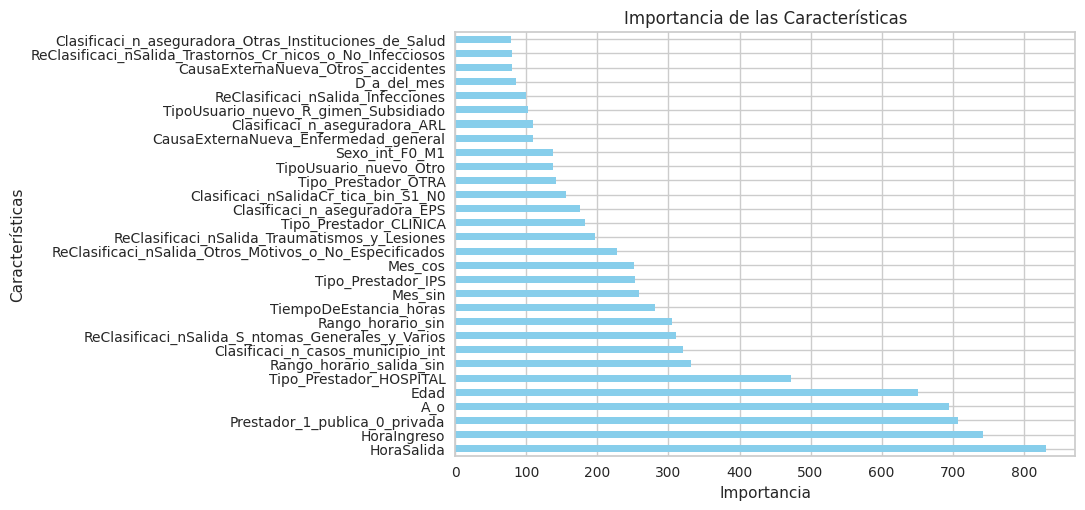

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Dividir en conjunto de entrenamiento y prueba
X = df_balanced_3.drop('DestinoUsuario', axis=1)
y = df_balanced_3['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Limpiar los nombres de las columnas (reemplazar caracteres no válidos por guiones bajos)
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)

# Crear el modelo LightGBM inicial
model = lgb.LGBMClassifier(
    num_leaves=31,        # Número de hojas en los árboles
    max_depth=-1,         # Profundidad máxima de los árboles
    learning_rate=0.05,   # Tasa de aprendizaje
    n_estimators=100,     # Número de árboles
    random_state=42       # Semilla para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Predecir los resultados para el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en conjunto de prueba: {accuracy:.4f}")

# Obtener las importancias de las características
importancias = model.feature_importances_

# Crear un DataFrame para visualizar las importancias
features = X_train.columns  # Asegúrate de que X_train tiene los nombres de las columnas
importancia_df = pd.DataFrame({
    'Feature': features,
    'Importance': importancias
})

# Ordenar las características por importancia
importancia_df = importancia_df.sort_values(by='Importance', ascending=False)

# Mostrar las primeras 10 características más importantes
print(importancia_df.head(30))

# Graficar las características más importantes
plt.figure(figsize=(10, 6))
importancia_df.head(30).plot(kind='barh', x='Feature', y='Importance', legend=False, color='skyblue')
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()


In [89]:
importancia_df.head(15)

,Feature,Importance
4,HoraSalida,831
3,HoraIngreso,743
1,Prestador_1_publica_0_privada,707
2,A_o,695
0,Edad,651
8,Tipo_Prestador_HOSPITAL,472
45,Rango_horario_salida_sin,332
11,Clasificaci_n_casos_municipio_int,320
53,ReClasificaci_nSalida_S_ntomas_Generales_y_Varios,311
43,Rango_horario_sin,305


In [92]:
df_balanced_3.columns

Index(['Edad', 'Prestador:1.publica/0.privada', 'Año', 'HoraIngreso',
       'HoraSalida', 'TiempoDeEstancia horas', 'Día del mes',
       'Tipo Prestador_CLINICA', 'Tipo Prestador_HOSPITAL',
       'Tipo Prestador_IPS', 'Tipo Prestador_OTRA',
       'Clasificación casos municipio_int', 'Region_departamento_Amazonica',
       'Region_departamento_Andina', 'Region_departamento_Caribe',
       'Region_departamento_Orinoquía', 'Region_departamento_Pacifica',
       'Cobertura servicios básicos departamento_int', 'Sexo_int_F0_M1',
       'ZonaResidencia_int_U0-R1', 'CausaExternaNueva_Accidente de trabajo',
       'CausaExternaNueva_Accidente de tránsito',
       'CausaExternaNueva_Enfermedad general',
       'CausaExternaNueva_Enfermedad laboral',
       'CausaExternaNueva_Mordeduras y picaduras de animales',
       'CausaExternaNueva_Otros accidentes',
       'CausaExternaNueva_Violencia y maltrato',
       'Clasificación aseguradora_ARL',
       'Clasificación aseguradora_Compañía de Seg

In [101]:
importance_df_selected_lgbm = df_balanced_3[['DestinoUsuario','HoraIngreso', 'Prestador:1.publica/0.privada', 'Año', 'Edad', 'Tipo Prestador_HOSPITAL',
                            'Clasificación casos municipio_int', 'ReClasificaciónSalida_Síntomas Generales y Varios', 
                            'Rango_horario_sin', 'Tipo Prestador_IPS']]

In [102]:
# Dividir en conjunto de entrenamiento y prueba
X = importance_df_selected_lgbm.drop('DestinoUsuario', axis=1)
y = importance_df_selected_lgbm['DestinoUsuario']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Limpiar los nombres de las columnas (reemplazar caracteres no válidos por guiones bajos)
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)

# Limpiar los nombres de las columnas (reemplazar caracteres no válidos por guiones bajos)
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)

# Crear el modelo LightGBM inicial
model = lgb.LGBMClassifier(
    num_leaves=31,        # Número de hojas en los árboles
    max_depth=-1,         # Profundidad máxima de los árboles
    learning_rate=0.05,   # Tasa de aprendizaje
    n_estimators=100,     # Número de árboles
    random_state=42       # Semilla para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
y_pred = model.fit(X_train, y_train)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 281255, number of used features: 9
[LightGBM] [Info] Start training from score -0.430935
[LightGBM] [Info] Start training from score -3.646741
[LightGBM] [Info] Start training from score -1.126942


InvalidParameterError: The 'y_pred' parameter of accuracy_score must be an array-like or a sparse matrix. Got LGBMClassifier(learning_rate=0.05, random_state=42) instead.

In [90]:
df_balanced_3.columns

Index(['Edad', 'Prestador:1.publica/0.privada', 'Año', 'HoraIngreso',
       'HoraSalida', 'TiempoDeEstancia horas', 'Día del mes',
       'Tipo Prestador_CLINICA', 'Tipo Prestador_HOSPITAL',
       'Tipo Prestador_IPS', 'Tipo Prestador_OTRA',
       'Clasificación casos municipio_int', 'Region_departamento_Amazonica',
       'Region_departamento_Andina', 'Region_departamento_Caribe',
       'Region_departamento_Orinoquía', 'Region_departamento_Pacifica',
       'Cobertura servicios básicos departamento_int', 'Sexo_int_F0_M1',
       'ZonaResidencia_int_U0-R1', 'CausaExternaNueva_Accidente de trabajo',
       'CausaExternaNueva_Accidente de tránsito',
       'CausaExternaNueva_Enfermedad general',
       'CausaExternaNueva_Enfermedad laboral',
       'CausaExternaNueva_Mordeduras y picaduras de animales',
       'CausaExternaNueva_Otros accidentes',
       'CausaExternaNueva_Violencia y maltrato',
       'Clasificación aseguradora_ARL',
       'Clasificación aseguradora_Compañía de Seg

# Selección Estadística con Chi-cuadrado

In [ ]:
# # Usar SelectKBest con Chi-cuadrado
# selector = SelectKBest(score_func=chi2, k=10)  # Selecciona las 10 mejores variables
# X_new = selector.fit_transform(X, y)

# # Ver las variables seleccionadas
# selected_features = X.columns[selector.get_support()]
# print("Variables seleccionadas:", selected_features)

## Información Mutua

In [77]:
# Usar SelectKBest con Información Mutua
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_new = selector.fit_transform(X, y)

# Ver las variables seleccionadas
selected_features = X.columns[selector.get_support()]
print("Variables seleccionadas:", selected_features)

Variables seleccionadas: Index(['Edad', 'Día del mes', 'HoraIngreso',
       'Clasificación casos municipio_int', 'Año', 'Tipo Prestador_HOSPITAL',
       'Mes_sin', 'Mes_cos', 'Día de la semana_int',
       'Prestador:1.publica/0.privada', 'Tipo Prestador_IPS',
       'Grupo_etario_int', 'Rango_horario_sin', 'Rango_horario_cos',
       'Tipo Prestador_CLINICA', 'CausaExternaNueva_Enfermedad general',
       'CausaExternaNueva_Otros accidentes',
       'CausaExternaNueva_Accidente de tránsito',
       'CausaExternaNueva_Accidente de trabajo',
       'CausaExternaNueva_Mordeduras y picaduras de animales'],
      dtype='object')


In [3]:
df_balanced_3 = pd.read_csv('df_balanced_3.csv')

In [19]:
selected_feature = df_balanced_3[['DestinoUsuario','Edad', 'Día del mes', 'HoraIngreso',
       'Clasificación casos municipio_int', 'Año', 'Tipo Prestador_HOSPITAL',
       'Mes_sin', 'Mes_cos', 'Día de la semana_int',
       'Prestador:1.publica/0.privada', 'Tipo Prestador_IPS',
       'Grupo_etario_int']]

In [40]:
selected_feature.DestinoUsuario.value_counts()

DestinoUsuario
1    228735
3    113760
2      9074
Name: count, dtype: int64

In [21]:
X = selected_feature.drop('DestinoUsuario', axis=1)
y = selected_feature['DestinoUsuario']

In [22]:
from imblearn.over_sampling import ADASYN


X_resampled, y_resampled = ADASYN(random_state=123).fit_resample(X, y)

In [30]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'num_leaves': [10, 20, 30, 40, 50],  # Controla la complejidad del árbol
    'max_depth': [5, 10, 15, 20, None],  # Profundidad máxima
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasa de aprendizaje (regularización)
    'n_estimators': [100, 200, 500],  # Número de árboles
    'min_child_samples': [10, 20, 30],  # Regularización: mínimo de muestras en nodos hoja
    'subsample': [0.6, 0.8, 1.0],  # Porcentaje de datos usados en cada árbol (regularización)
    'colsample_bytree': [0.6, 0.8, 1.0],  # Porcentaje de features usadas en cada árbol
    'lambda_l1': [0.0, 0.1, 1.0],  # Regularización L1 (Lasso)
    'lambda_l2': [0.0, 0.1, 1.0]   # Regularización L2 (Ridge)
}

# Inicializar el modelo
lgbm = lgb.LGBMClassifier(random_state=42)

# Configurar la búsqueda aleatoria
lgbm_random = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
lgbm_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", lgbm_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_lgbm = lgbm_random.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 445209, number of used features: 12
[LightGBM] [Info] Start training from score -1.112495
[LightGBM] [Info] Start training from score -1.108560
[LightGBM] [Info] Start training from score -1.075203
[LightGBM] 

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles
    'max_depth': [10, 20, 30, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimas muestras en una hoja
    'max_features': ['sqrt', 'log2', None],  # Máximo de features consideradas
    'bootstrap': [True, False]  # Si se usa bootstrap para muestreo
}

# Inicializar el modelo
rf = RandomForestClassifier(random_state=42)

# Configurar la búsqueda aleatoria
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
rf_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", rf_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

# Importar métricas
from sklearn.metrics import classification_report, accuracy_score

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = best_rf.predict(X_train)
y_train_prob = best_rf.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)

In [65]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9427
Precision (macro): 0.9431
Recall (macro): 0.9418
F1 Score (macro): 0.9420
AUC (One-vs-Rest): 0.9942
              precision    recall  f1-score   support

           1       0.91      0.95      0.93    182909
           2       0.97      0.99      0.98    182298
           3       0.95      0.89      0.92    173075

    accuracy                           0.94    538282
   macro avg       0.94      0.94      0.94    538282
weighted avg       0.94      0.94      0.94    538282

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8533
Precision (macro): 0.8510
Recall (macro): 0.8514
F1 Score (macro): 0.8502
AUC (One-vs-Rest): 0.9571
              precision    recall  f1-score   support

           1       0.81      0.84      0.83     45826
           2       0.92      0.97      0.95     45556
           3       0.82      0.74      0.78     43189

    accuracy                       

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = best_rf.predict(X_train)
y_train_prob = best_rf.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)

In [65]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9427
Precision (macro): 0.9431
Recall (macro): 0.9418
F1 Score (macro): 0.9420
AUC (One-vs-Rest): 0.9942
              precision    recall  f1-score   support

           1       0.91      0.95      0.93    182909
           2       0.97      0.99      0.98    182298
           3       0.95      0.89      0.92    173075

    accuracy                           0.94    538282
   macro avg       0.94      0.94      0.94    538282
weighted avg       0.94      0.94      0.94    538282

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8533
Precision (macro): 0.8510
Recall (macro): 0.8514
F1 Score (macro): 0.8502
AUC (One-vs-Rest): 0.9571
              precision    recall  f1-score   support

           1       0.81      0.84      0.83     45826
           2       0.92      0.97      0.95     45556
           3       0.82      0.74      0.78     43189

    accuracy                       

In [37]:
import pickle
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(best_rf, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/best_rf_07_02.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/best_rf_07_02.pkl


In [38]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


### Regresión logística

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [35]:
# Inicializar el modelo con regularización L2 (default)
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=500, random_state=42)

# Entrenar con los datos de entrenamiento
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

In [36]:
# Predicciones en el conjunto de prueba
y_pred = log_reg.predict(X_test)

# Evaluar métricas de desempeño
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.575286245139403
              precision    recall  f1-score   support

           1       0.54      0.41      0.47     45789
           2       0.57      0.74      0.65     45867
           3       0.61      0.57      0.59     47473

    accuracy                           0.58    139129
   macro avg       0.57      0.58      0.57    139129
weighted avg       0.57      0.58      0.57    139129



# Diferente balanceo

In [4]:
df_balanced_3 = pd.read_csv('df_balanced_3.csv')

In [5]:
df_balanced_3.columns

Index(['Edad', 'Prestador:1.publica/0.privada', 'Año', 'HoraIngreso',
       'HoraSalida', 'TiempoDeEstancia horas', 'Día del mes',
       'Tipo Prestador_CLINICA', 'Tipo Prestador_HOSPITAL',
       'Tipo Prestador_IPS', 'Tipo Prestador_OTRA',
       'Clasificación casos municipio_int', 'Region_departamento_Amazonica',
       'Region_departamento_Andina', 'Region_departamento_Caribe',
       'Region_departamento_Orinoquía', 'Region_departamento_Pacifica',
       'Cobertura servicios básicos departamento_int', 'Sexo_int_F0_M1',
       'ZonaResidencia_int_U0-R1', 'CausaExternaNueva_Accidente de trabajo',
       'CausaExternaNueva_Accidente de tránsito',
       'CausaExternaNueva_Enfermedad general',
       'CausaExternaNueva_Enfermedad laboral',
       'CausaExternaNueva_Mordeduras y picaduras de animales',
       'CausaExternaNueva_Otros accidentes',
       'CausaExternaNueva_Violencia y maltrato',
       'Clasificación aseguradora_ARL',
       'Clasificación aseguradora_Compañía de Seg

In [42]:
selected_feature = df_balanced_3[['DestinoUsuario','Edad', 'Día del mes', 'HoraIngreso',
       'Clasificación casos municipio_int', 'Año', 'Tipo Prestador_HOSPITAL',
       'Mes_sin', 'Mes_cos', 'Día de la semana_int',
       'Prestador:1.publica/0.privada', 'Tipo Prestador_IPS',
       'Grupo_etario_int']]

In [43]:
selected_feature.DestinoUsuario.value_counts()

DestinoUsuario
1    228735
3    113760
2      9074
Name: count, dtype: int64

In [44]:
X = selected_feature.drop('DestinoUsuario', axis=1)
y = selected_feature['DestinoUsuario']

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [51]:
y_resampled.value_counts()

DestinoUsuario
1    228735
2    228735
3    228735
Name: count, dtype: int64

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles
    'max_depth': [10, 20, 30, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimas muestras en una hoja
    'max_features': ['sqrt', 'log2', None],  # Máximo de features consideradas
    'bootstrap': [True, False]  # Si se usa bootstrap para muestreo
}

# Inicializar el modelo
rf = RandomForestClassifier(random_state=42)

# Configurar la búsqueda aleatoria
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
rf_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", rf_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

# Importar métricas
from sklearn.metrics import classification_report, accuracy_score

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 5.2min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.9min
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.4min
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; 

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = best_rf.predict(X_train)
y_train_prob = best_rf.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)

[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 8.6min
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 4.3min
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 7.4min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, m

In [55]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9500
Precision (macro): 0.9504
Recall (macro): 0.9500
F1 Score (macro): 0.9498
AUC (One-vs-Rest): 0.9957
              precision    recall  f1-score   support

           1       0.92      0.96      0.94    182950
           2       0.98      0.99      0.98    182993
           3       0.96      0.91      0.93    183021

    accuracy                           0.95    548964
   macro avg       0.95      0.95      0.95    548964
weighted avg       0.95      0.95      0.95    548964

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8507
Precision (macro): 0.8489
Recall (macro): 0.8507
F1 Score (macro): 0.8491
AUC (One-vs-Rest): 0.9566
              precision    recall  f1-score   support

           1       0.80      0.83      0.82     45785
           2       0.93      0.97      0.95     45742
           3       0.82      0.75      0.78     45714

    accuracy                       

In [56]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'num_leaves': [10, 20, 30, 40, 50],  # Controla la complejidad del árbol
    'max_depth': [5, 10, 15, 20, None],  # Profundidad máxima
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasa de aprendizaje (regularización)
    'n_estimators': [100, 200, 500],  # Número de árboles
    'min_child_samples': [10, 20, 30],  # Regularización: mínimo de muestras en nodos hoja
    'subsample': [0.6, 0.8, 1.0],  # Porcentaje de datos usados en cada árbol (regularización)
    'colsample_bytree': [0.6, 0.8, 1.0],  # Porcentaje de features usadas en cada árbol
    'lambda_l1': [0.0, 0.1, 1.0],  # Regularización L1 (Lasso)
    'lambda_l2': [0.0, 0.1, 1.0]   # Regularización L2 (Ridge)
}

# Inicializar el modelo
lgbm = lgb.LGBMClassifier(random_state=42, verbose=-1)

# Configurar la búsqueda aleatoria
lgbm_random = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
lgbm_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", lgbm_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_lgbm = lgbm_random.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'subsample': 0.6, 'num_leaves': 40, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.2, 'lambda_l2': 0.1, 'lambda_l1': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.7847654855327489
              precision    recall  f1-score   support

           1       0.73      0.82      0.77     45785
           2       0.85      0.87      0.86     45742
           3       0.78      0.66      0.71     45714

    accuracy                           0.78    137241
   macro avg       0.79      0.78      0.78    137241
weighted avg       0.79      0.78      0.78    137241

[CV] END colsample_bytree=0.6, lambda_l1=0.0, lambda_l2=0.0, learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=100, num_leaves=20, subsample=1.0; total time=  43.6s
[CV] END colsample_bytree=1.0, lambda_l1=0.0, lambda_l2=1.0, learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=500, num_

## Otra técnica de balanceo

In [25]:
df_balanced_3 = pd.read_csv('df_balanced_3.csv')

In [26]:
selected_feature = df_balanced_3[['DestinoUsuario','Edad', 'Día del mes', 'HoraIngreso',
       'Clasificación casos municipio_int', 'Año', 'Tipo Prestador_HOSPITAL',
       'Mes_sin', 'Mes_cos', 'Día de la semana_int',
       'Prestador:1.publica/0.privada', 'Tipo Prestador_IPS',
       'Grupo_etario_int']]

In [27]:
selected_feature.DestinoUsuario.value_counts()

DestinoUsuario
1    228735
3    113760
2      9074
Name: count, dtype: int64

In [28]:
X = selected_feature.drop('DestinoUsuario', axis=1)
y = selected_feature['DestinoUsuario']

In [29]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

In [30]:
y_resampled.value_counts()

DestinoUsuario
2    228648
3    222076
1    222007
Name: count, dtype: int64

In [31]:
X_resampled.to_csv('X_resampled_SMOTETomek.csv', index=False)
y_resampled.to_csv('y_resampled_SMOTETomek.csv', index=False)

In [32]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'num_leaves': [10, 20, 30, 40, 50],  # Controla la complejidad del árbol
    'max_depth': [5, 10, 15, 20, None],  # Profundidad máxima
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasa de aprendizaje (regularización)
    'n_estimators': [100, 200, 500],  # Número de árboles
    'min_child_samples': [10, 20, 30],  # Regularización: mínimo de muestras en nodos hoja
    'subsample': [0.6, 0.8, 1.0],  # Porcentaje de datos usados en cada árbol (regularización)
    'colsample_bytree': [0.6, 0.8, 1.0],  # Porcentaje de features usadas en cada árbol
    'lambda_l1': [0.0, 0.1, 1.0],  # Regularización L1 (Lasso)
    'lambda_l2': [0.0, 0.1, 1.0]   # Regularización L2 (Ridge)
}

# Inicializar el modelo
lgbm = lgb.LGBMClassifier(random_state=42, verbose=-1)

# Configurar la búsqueda aleatoria
lgbm_random = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
lgbm_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", lgbm_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_lgbm = lgbm_random.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'subsample': 0.6, 'num_leaves': 40, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.2, 'lambda_l2': 0.1, 'lambda_l1': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.7880591912119929
              precision    recall  f1-score   support

           1       0.73      0.83      0.78     44412
           2       0.85      0.87      0.86     45857
           3       0.78      0.67      0.72     44278

    accuracy                           0.79    134547
   macro avg       0.79      0.79      0.79    134547
weighted avg       0.79      0.79      0.79    134547



In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles
    'max_depth': [10, 20, 30, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimas muestras en una hoja
    'max_features': ['sqrt', 'log2', None],  # Máximo de features consideradas
    'bootstrap': [True, False]  # Si se usa bootstrap para muestreo
}

# Inicializar el modelo
rf = RandomForestClassifier(random_state=42)

# Configurar la búsqueda aleatoria
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
rf_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", rf_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

# Importar métricas
from sklearn.metrics import classification_report, accuracy_score

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END colsample_bytree=0.6, lambda_l1=0.1, lambda_l2=1.0, learning_rate=0.2, max_depth=15, min_child_samples=10, n_estimators=100, num_leaves=10, subsample=0.6; total time=  15.0s
[CV] END colsample_bytree=0.6, lambda_l1=0.0, lambda_l2=0.0, learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=100, num_leaves=20, subsample=1.0; total time=  23.7s
[CV] END colsample_bytree=0.6, lambda_l1=0.0, lambda_l2=1.0, learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=100, num_leaves=40, subsample=0.8; total time=  30.9s
[CV] END colsample_bytree=0.8, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.2, max_depth=5, min_child_samples=20, n_estimators=200, num_leaves=40, subsample=0.6; total time=  29.2s
[CV] END colsample_bytree=0.6, lambda_l1=0.1, lambda_l2=1.0, learning_rate=0.2, max_depth=15, min_child_samples=10, n_estimators=100, num_leaves=10, subsample=0.6; total time=  30.1s
[CV] END colsample_bytre

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# ✔ y_train - 1: Transforma las clases [1, 2, 3] a [0, 1, 2] para que XGBoost las acepte.
# ✔ y_pred + 1: Vuelve las predicciones a la escala original ([1, 2, 3]).
# Remapear clases para que empiecen en 0 (evitar error de XGBoost)
y_train = np.array(y_train) - 1
y_test = np.array(y_test) - 1

# Definir el modelo base
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Para clasificación multiclase
    num_class=len(set(y_train)),  # Número de clases
    eval_metric="mlogloss",  # Métrica de evaluación
    use_label_encoder=False,
    random_state=42
)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 300, 500],  # Número de árboles
    'max_depth': [3, 6, 10],  # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'subsample': [0.6, 0.8, 1.0],  # Porcentaje de datos usados por árbol
    'colsample_bytree': [0.6, 0.8, 1.0],  # Porcentaje de features usadas en cada árbol
    'gamma': [0, 0.1, 0.2],  # Regularización para evitar overfitting
    'scale_pos_weight': [1, 2, 5]  # Ajuste para clases desbalanceadas
}

# Configurar búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=2,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1,  # Usa todos los núcleos disponibles
    random_state=42
)

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", random_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Mostrar métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", 

Mejores hiperparámetros: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.7856654783125372
              precision    recall  f1-score   support

           0       0.73      0.81      0.77     44393
           1       0.84      0.89      0.86     45782
           2       0.78      0.66      0.72     44465

    accuracy                           0.79    134640
   macro avg       0.79      0.78      0.78    134640
weighted avg       0.79      0.79      0.78    134640



In [2]:
import boto3
import pickle
from io import BytesIO

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Especificar el bucket y la clave del objeto
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/best_xgb_07_02.pkl'

# Descargar el modelo desde S3
model_buffer = BytesIO()
s3.download_fileobj(bucket_name, object_name, model_buffer)

# Mover el puntero al inicio del buffer
model_buffer.seek(0)

# Cargar el modelo con pickle
best_xgb = pickle.load(model_buffer)

print("Modelo cargado exitosamente.")


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Modelo cargado exitosamente.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

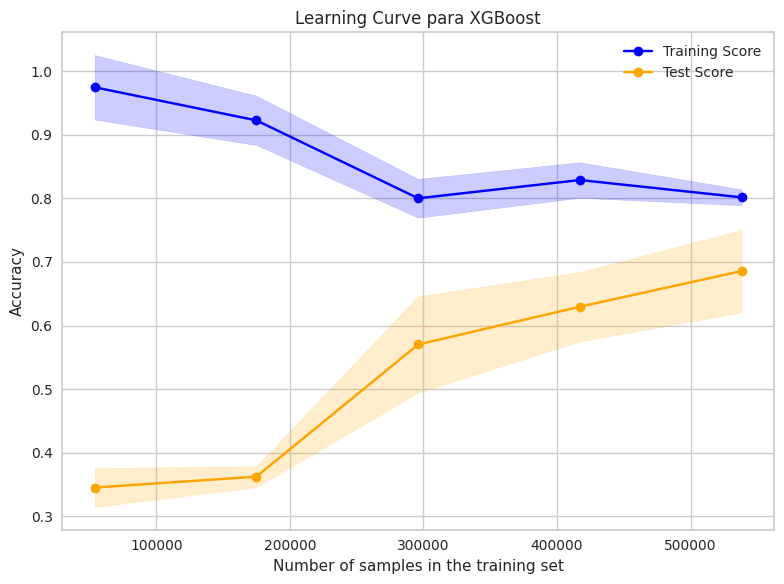

In [19]:
# Suprimir advertencias generales
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import learning_curve



y_resampled = np.array(y_resampled) - 1


# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)



# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para XGBoost")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = best_xgb.predict(X_train)
y_train_prob = best_xgb.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = best_xgb.predict(X_test)
y_test_prob = best_xgb.predict_proba(X_test)

In [98]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.7932
Precision (macro): 0.7937
Recall (macro): 0.7923
F1 Score (macro): 0.7905
AUC (One-vs-Rest): 0.9296
              precision    recall  f1-score   support

           0       0.74      0.82      0.77    177595
           1       0.85      0.89      0.87    182791
           2       0.79      0.67      0.73    177798

    accuracy                           0.79    538184
   macro avg       0.79      0.79      0.79    538184
weighted avg       0.79      0.79      0.79    538184

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.7857
Precision (macro): 0.7857
Recall (macro): 0.7845
F1 Score (macro): 0.7828
AUC (One-vs-Rest): 0.9235
              precision    recall  f1-score   support

           0       0.73      0.80      0.77     44412
           1       0.85      0.89      0.87     45857
           2       0.78      0.66      0.72     44278

    accuracy                       

In [85]:
import pickle
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(best_xgb, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/best_xgb_07_02.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/best_xgb_07_02.pkl


In [86]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


## Otra variable

In [33]:
df_balanced_3 = pd.read_csv('df_balanced_3.csv')

In [34]:
selected_feature = df_balanced_3[['DestinoUsuario','Edad', 'Día del mes', 'HoraIngreso',
       'Clasificación casos municipio_int', 'Año', 'Tipo Prestador_HOSPITAL',
       'Mes_sin', 'Mes_cos', 'Día de la semana_int',
       'Prestador:1.publica/0.privada', 'Tipo Prestador_IPS',
       'CausaExternaNueva_Enfermedad general']]

In [35]:
selected_feature.DestinoUsuario.value_counts()

DestinoUsuario
1    228735
3    113760
2      9074
Name: count, dtype: int64

In [36]:
X = selected_feature.drop('DestinoUsuario', axis=1)
y = selected_feature['DestinoUsuario']

In [37]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

In [38]:
y_resampled.value_counts()

DestinoUsuario
2    228663
3    222328
1    222276
Name: count, dtype: int64

In [39]:
X_resampled.to_csv('X_resampled_SMOTETomek_s2.csv', index=False)
y_resampled.to_csv('y_resampled_SMOTETomek_s2.csv', index=False)

In [40]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'num_leaves': [10, 20, 30, 40, 50],  # Controla la complejidad del árbol
    'max_depth': [5, 10, 15, 20, None],  # Profundidad máxima
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasa de aprendizaje (regularización)
    'n_estimators': [100, 200, 500],  # Número de árboles
    'min_child_samples': [10, 20, 30],  # Regularización: mínimo de muestras en nodos hoja
    'subsample': [0.6, 0.8, 1.0],  # Porcentaje de datos usados en cada árbol (regularización)
    'colsample_bytree': [0.6, 0.8, 1.0],  # Porcentaje de features usadas en cada árbol
    'lambda_l1': [0.0, 0.1, 1.0],  # Regularización L1 (Lasso)
    'lambda_l2': [0.0, 0.1, 1.0]   # Regularización L2 (Ridge)
}

# Inicializar el modelo
lgbm = lgb.LGBMClassifier(random_state=42, verbose=-1)

# Configurar la búsqueda aleatoria
lgbm_random = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
lgbm_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", lgbm_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_lgbm = lgbm_random.best_estimator_
y_pred = best_lgbm.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'subsample': 0.6, 'num_leaves': 40, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.2, 'lambda_l2': 0.1, 'lambda_l1': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.7918962674707027
              precision    recall  f1-score   support

           1       0.74      0.83      0.78     44391
           2       0.86      0.87      0.86     45990
           3       0.79      0.67      0.72     44273

    accuracy                           0.79    134654
   macro avg       0.79      0.79      0.79    134654
weighted avg       0.79      0.79      0.79    134654



In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles
    'max_depth': [10, 20, 30, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimas muestras en una hoja
    'max_features': ['sqrt', 'log2', None],  # Máximo de features consideradas
    'bootstrap': [True, False]  # Si se usa bootstrap para muestreo
}

# Inicializar el modelo
rf = RandomForestClassifier(random_state=42)

# Configurar la búsqueda aleatoria
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=5,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralelización en todos los núcleos
)

# Entrenar con los datos de entrenamiento
rf_random.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", rf_random.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

# Importar métricas
from sklearn.metrics import classification_report, accuracy_score

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=10, n_estimators=500, scale_pos_weight=5, subsample=0.8; total time= 3.1min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=500, scale_pos_weight=2, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=10, n_estimators=500, scale_pos_weight=5, subsample=0.8; total time= 2.7min
[CV] END colsample_bytree=0.6, lambda_l1=0.1, lambda_l2=1.0, learning_rate=0.2, max_depth=15, min_child_samples=10, n_estimators=100, num_leaves=10, subsample=0.6; total time=  31.0s
[CV] END colsample_bytree=0.6, lambda_l1=0.0, lambda_l2=0.0, learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=100, num_leaves=20, subsample=1.0; total time=  52.0s
[CV] END colsample_bytree=0.6, lambda_l1=0.0, lambda_l2=1.0, learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=10

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = best_rf.predict(X_train)
y_train_prob = best_rf.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)

In [43]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9535
Precision (macro): 0.9536
Recall (macro): 0.9532
F1 Score (macro): 0.9532
AUC (One-vs-Rest): 0.9963
              precision    recall  f1-score   support

           1       0.93      0.96      0.94    177885
           2       0.98      0.99      0.98    182673
           3       0.96      0.91      0.94    178055

    accuracy                           0.95    538613
   macro avg       0.95      0.95      0.95    538613
weighted avg       0.95      0.95      0.95    538613

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8595
Precision (macro): 0.8571
Recall (macro): 0.8581
F1 Score (macro): 0.8569
AUC (One-vs-Rest): 0.9607
              precision    recall  f1-score   support

           1       0.82      0.84      0.83     44391
           2       0.93      0.97      0.95     45990
           3       0.83      0.76      0.79     44273

    accuracy                       

In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# ✔ y_train - 1: Transforma las clases [1, 2, 3] a [0, 1, 2] para que XGBoost las acepte.
# ✔ y_pred + 1: Vuelve las predicciones a la escala original ([1, 2, 3]).
# Remapear clases para que empiecen en 0 (evitar error de XGBoost)
y_train = np.array(y_train) - 1
y_test = np.array(y_test) - 1

# Definir el modelo base
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Para clasificación multiclase
    num_class=len(set(y_train)),  # Número de clases
    eval_metric="mlogloss",  # Métrica de evaluación
    use_label_encoder=False,
    random_state=42
)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 300, 500],  # Número de árboles
    'max_depth': [3, 6, 10],  # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'subsample': [0.6, 0.8, 1.0],  # Porcentaje de datos usados por árbol
    'colsample_bytree': [0.6, 0.8, 1.0],  # Porcentaje de features usadas en cada árbol
    'gamma': [0, 0.1, 0.2],  # Regularización para evitar overfitting
    'scale_pos_weight': [1, 2, 5]  # Ajuste para clases desbalanceadas
}

# Configurar búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=2,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1,  # Usa todos los núcleos disponibles
    random_state=42
)

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", random_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Mostrar métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


NameError: name 'X_resampled' is not defined

In [14]:
# import boto3
# import pickle
# from io import BytesIO

# # Configurar cliente de S3
# s3 = boto3.client('s3', region_name='us-east-1')

# # Especificar el bucket y la clave del objeto
# bucket_name = 'evolucion-modelo-operativo'
# object_name = 'modelos/best_xgb_07_02.pkl'

# # Descargar el modelo desde S3
# model_buffer = BytesIO()
# s3.download_fileobj(bucket_name, object_name, model_buffer)

# # Mover el puntero al inicio del buffer
# model_buffer.seek(0)

# # Cargar el modelo con pickle
# best_xgb = pickle.load(model_buffer)

# print("Modelo cargado exitosamente.")


Modelo cargado exitosamente.


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=500, scale_pos_weight=2, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=500, scale_pos_weight=2, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=500, scale_pos_weight=2, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=10, n_estimators=500, scale_pos_weight=5, subsample=0.8; total time= 2.9min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=10, n_estimators=500, scale_pos_weight=5, subsample=0.8; total time= 2.9min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=10, n_estimators=500, scale_pos_weight=5, subsample=0.8; total time= 2.9min
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=6, n_estimators=500, scale_pos_weight=2, subsample=

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

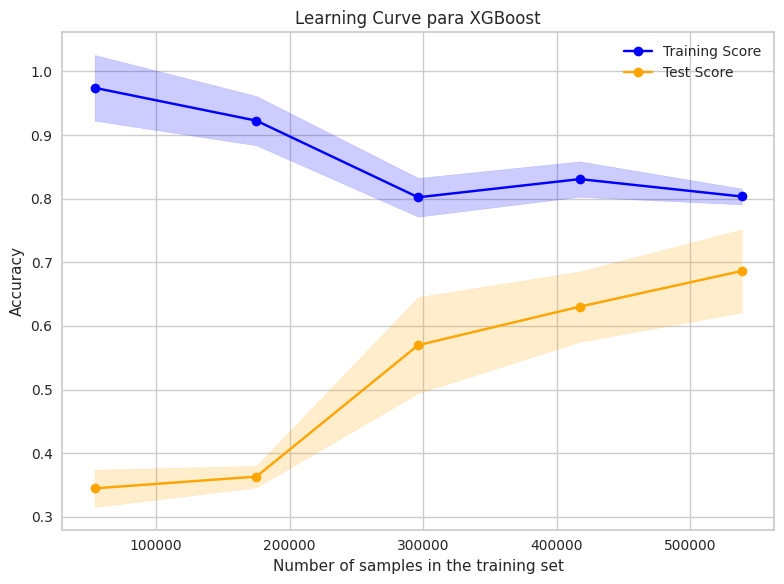

In [45]:
# Suprimir advertencias generales
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import learning_curve



y_resampled = np.array(y_resampled) - 1


# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)



# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para XGBoost")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = best_xgb.predict(X_train)
y_train_prob = best_xgb.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = best_xgb.predict(X_test)
y_test_prob = best_xgb.predict_proba(X_test)

In [47]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.7952
Precision (macro): 0.7957
Recall (macro): 0.7944
F1 Score (macro): 0.7925
AUC (One-vs-Rest): 0.9306
              precision    recall  f1-score   support

           0       0.74      0.82      0.78    177885
           1       0.85      0.89      0.87    182673
           2       0.80      0.67      0.73    178055

    accuracy                           0.80    538613
   macro avg       0.80      0.79      0.79    538613
weighted avg       0.80      0.80      0.79    538613

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.7887
Precision (macro): 0.7885
Recall (macro): 0.7874
F1 Score (macro): 0.7856
AUC (One-vs-Rest): 0.9257
              precision    recall  f1-score   support

           0       0.74      0.81      0.77     44391
           1       0.85      0.89      0.87     45990
           2       0.78      0.67      0.72     44273

    accuracy                       

In [48]:
import pickle
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(best_xgb, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/best_xgb_08_02.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/best_xgb_08_02.pkl


In [49]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


In [83]:
# ! pip install catboost

In [84]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from collections import Counter

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# ✔ y_train - 1: Transforma las clases [1, 2, 3] a [0, 1, 2] para que XGBoost las acepte.
# ✔ y_pred + 1: Vuelve las predicciones a la escala original ([1, 2, 3]).
# # Remapear clases para que empiecen en 0 (evitar error de XGBoost)
# y_train = np.array(y_train) - 1
# y_test = np.array(y_test) - 1


# 🔹 Ajustar pesos de clases (para balancear)
class_counts = Counter(y_train)
max_count = max(class_counts.values())
class_weights = {k: max_count / v for k, v in class_counts.items()}

# 🔹 Definir el modelo CatBoost
catboost_model = CatBoostClassifier(
    iterations=1000,       # Aumentar para mejor rendimiento
    learning_rate=0.05,     # Tasa de aprendizaje
    depth=6,               # Profundidad del árbol
    loss_function='MultiClass',
    eval_metric='MultiClass',
    class_weights=list(class_weights.values()),  # Pesos de clases
    random_seed=42,
    verbose=100  # Para ver el progreso
)

# 🔹 Entrenar el modelo
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# 🔹 Predicciones
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)

# 🔹 Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(pd.get_dummies(y_test), y_pred_proba, multi_class='ovr')
report = classification_report(y_test, y_pred)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ AUC: {auc:.4f}")
print("🔹 Classification Report:\n", report)


0:	learn: 1.0725782	test: 1.0726168	best: 1.0726168 (0)	total: 122ms	remaining: 2m 2s
100:	learn: 0.6441958	test: 0.6434165	best: 0.6434165 (100)	total: 6.69s	remaining: 59.5s
200:	learn: 0.5939214	test: 0.5936033	best: 0.5936033 (200)	total: 13.1s	remaining: 52.1s
300:	learn: 0.5744483	test: 0.5745175	best: 0.5745175 (300)	total: 19.5s	remaining: 45.2s
400:	learn: 0.5607399	test: 0.5612879	best: 0.5612879 (400)	total: 25.9s	remaining: 38.7s
500:	learn: 0.5507466	test: 0.5519096	best: 0.5519096 (500)	total: 32.2s	remaining: 32s
600:	learn: 0.5422937	test: 0.5442004	best: 0.5442004 (600)	total: 38.5s	remaining: 25.6s
700:	learn: 0.5348176	test: 0.5373143	best: 0.5373143 (700)	total: 44.9s	remaining: 19.2s
800:	learn: 0.5281520	test: 0.5311183	best: 0.5311183 (800)	total: 51.3s	remaining: 12.8s
900:	learn: 0.5221568	test: 0.5256492	best: 0.5256492 (900)	total: 57.8s	remaining: 6.35s
999:	learn: 0.5169632	test: 0.5209794	best: 0.5209794 (999)	total: 1m 4s	remaining: 0us

bestTest = 0.5209

# Graficos

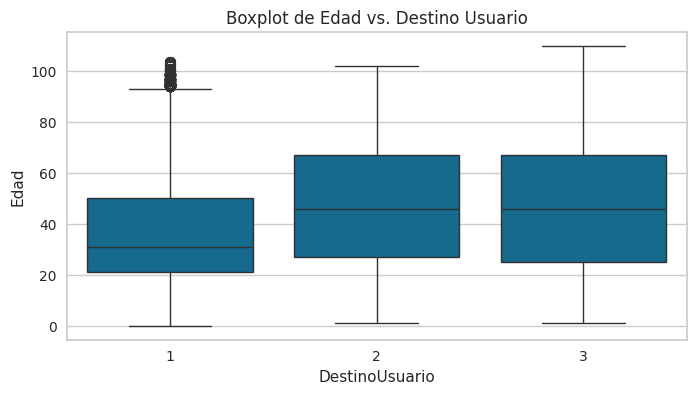

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama df, la variable numérica es 'var_numerica'
# y la variable objetivo es 'target'
plt.figure(figsize=(8, 4))
sns.boxplot(x="DestinoUsuario", y="Edad", data=selected_feature)
plt.title("Boxplot de Edad vs. Destino Usuario")
plt.show()


In [12]:
import scipy.stats as stats

# Agrupar las edades por cada categoría de DestinoUsuario
grupo1 = selected_feature[selected_feature["DestinoUsuario"] == 1]["Edad"]
grupo2 = selected_feature[selected_feature["DestinoUsuario"] == 2]["Edad"]
grupo3 = selected_feature[selected_feature["DestinoUsuario"] == 3]["Edad"]

# Prueba ANOVA
f_stat, p_value = stats.f_oneway(grupo1, grupo2, grupo3)

print(f'Estadístico F: {f_stat:.4f}')
print(f'Valor p: {p_value:.4f}')

# Interpretación del valor p
if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Hay diferencias significativas entre las medias de Edad en los distintos DestinoUsuario.")
else:
    print("No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que las medias de Edad sean diferentes entre los grupos.")


Estadístico F: 7936.9501
Valor p: 0.0000
Rechazamos la hipótesis nula: Hay diferencias significativas entre las medias de Edad en los distintos DestinoUsuario.


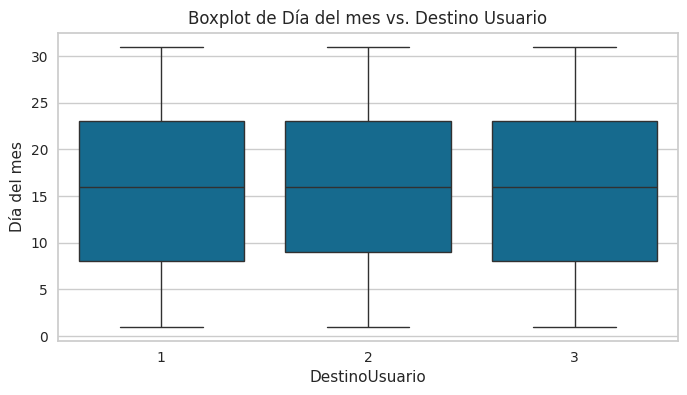

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama df, la variable numérica es 'var_numerica'
# y la variable objetivo es 'target'
plt.figure(figsize=(8, 4))
sns.boxplot(x="DestinoUsuario", y="Día del mes", data=selected_feature)
plt.title("Boxplot de Día del mes vs. Destino Usuario")
plt.show()

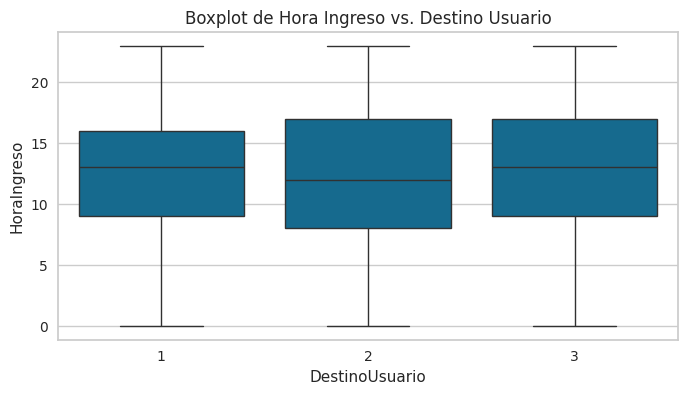

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama df, la variable numérica es 'var_numerica'
# y la variable objetivo es 'target'
plt.figure(figsize=(8, 4))
sns.boxplot(x="DestinoUsuario", y="HoraIngreso", data=selected_feature)
plt.title("Boxplot de Hora Ingreso vs. Destino Usuario")
plt.show()

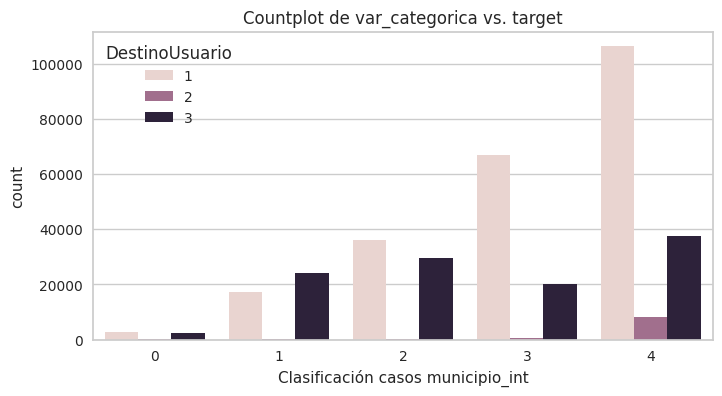

In [17]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Clasificación casos municipio_int", hue="DestinoUsuario", data=selected_feature)
plt.title("Countplot de var_categorica vs. target")
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import matplotlib as mpl
import logging
mpl.font_manager._log.setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore", message="findfont:")


# Visualizar las relaciones con un pairplot
sns.pairplot(df_balanced_3[['DestinoUsuario','Día del mes', 'HoraIngreso']]
             , hue='DestinoUsuario')
plt.suptitle('Pairplot de Iris (coloreado por la variable objetivo)', y=1.02)
plt.show()

In [ ]:
# Importar las librerías necesarias
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Dividir en conjunto de entrenamiento y prueba
X = df_balanced_3.drop('DestinoUsuario', axis=1)
y = df_balanced_3['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Crear el modelo SVM
# # En este caso, utilizamos un kernel lineal, pero se puede cambiar a 'rbf', 'poly', etc.
# svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# # Entrenar el modelo con los datos de entrenamiento
# svm_model.fit(X_train, y_train)

# # Realizar predicciones sobre el conjunto de prueba
# y_pred = svm_model.predict(X_test)

# # Evaluar el desempeño del modelo calculando la precisión
# accuracy = accuracy_score(y_test, y_pred)
# print("Precisión del modelo:", accuracy)

# Importar las librerías necesarias
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Crear el modelo de regresión logística
# El parámetro max_iter asegura que el algoritmo tenga suficientes iteraciones para converger
logreg = LogisticRegression(max_iter=200, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
logreg.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = logreg.predict(X_test)

# Evaluar el desempeño del modelo calculando la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo de regresión logística:", accuracy)



## 

In [ ]:
.

In [ ]:
# Dividir en conjunto de entrenamiento y prueba
X = importance_df_selected.drop('DestinoUsuario', axis=1)
y = importance_df_selected['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

In [ ]:
.

In [ ]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [ ]:
.

In [ ]:
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np



# Paso 2: Reindexar las clases de DestinoUsuario para evitar errores en CNN
le = LabelEncoder()
y_medellin_encoded = le.fit_transform(df_medellin['DestinoUsuario'])  # Convierte {1,2,3} → {0,1,2}

# Seleccionar solo variables numéricas para entrenamiento
X_medellin = df_medellin.drop(columns=['Municipio', 'DestinoUsuario'])

# Paso 3: Aplicar Condensed Nearest Neighbour (CNN) para reducir redundancia y mantener representatividad
cnn = CondensedNearestNeighbour(n_jobs=-1)
X_resampled, y_resampled_encoded = cnn.fit_resample(X_medellin, y_medellin_encoded)

# Convertir de nuevo a clases originales
y_resampled = le.inverse_transform(y_resampled_encoded)

# Convertir a DataFrame
df_medellin_resampled = pd.DataFrame(X_resampled, columns=X_medellin.columns)
df_medellin_resampled['Municipio'] = 'MEDELLIN'
df_medellin_resampled['DestinoUsuario'] = y_resampled

# Paso 4: Combinar con los demás municipios
df_balanced = pd.concat([df_medellin_resampled, df_otros], ignore_index=True)



In [ ]:
.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from imblearn.under_sampling import InstanceHardnessThreshold
from collections import Counter

# Reindexar las clases para que sean consecutivas (0,1,2)
le = LabelEncoder()
y_medellin_encoded = le.fit_transform(y_medellin)  # Convierte {1,2,3} → {0,1,2}

# Configurar el modelo base LightGBM para clasificación multiclase
clf = lgb.LGBMClassifier(n_estimators=100, objective="multiclass", num_class=3, random_state=42)


In [ ]:
# Aplicar Instance Hardness Threshold (IHT)
iht = InstanceHardnessThreshold(estimator=clf, random_state=42, n_jobs=-1)
X_resampled, y_resampled_encoded = iht.fit_resample(X_medellin, y_medellin_encoded)

# Convertir las clases de nuevo a los valores originales {1,2,3}
y_resampled = le.inverse_transform(y_resampled_encoded)

# Convertir a DataFrame
df_medellin_resampled = pd.DataFrame(X_resampled, columns=X_medellin.columns)
df_medellin_resampled['Municipio'] = 'MEDELLIN'
df_medellin_resampled['DestinoUsuario'] = y_resampled

# Combinar con los demás municipios
df_balanced = pd.concat([df_medellin_resampled, df_otros], ignore_index=True)

# Verificar la nueva distribución
print("Distribución después de IHT en Medellín:", Counter(df_balanced[df_balanced['Municipio'] == 'MEDELLIN']['DestinoUsuario']))

In [ ]:
df_balanced.Municipio.value_counts()

In [ ]:
df_balanced.shape

In [ ]:
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import re

# Renombrar columnas eliminando espacios, guiones y caracteres especiales
X_medellin.columns = [re.sub(r'[^A-Za-z0-9_]', '_', col) for col in X_medellin.columns]

# Verificar los nuevos nombres de las columnas
print("Nombres de columnas corregidos:", X_medellin.columns)

# Dividir datos de Medellín en train y test
X_train, X_test, y_train, y_test = train_test_split(X_medellin, y_medellin, test_size=0.2, random_state=42, stratify=y_medellin)

# Configurar el modelo LightGBM
clf = lgb.LGBMClassifier(n_estimators=100, objective="multiclass", num_class=3, random_state=42)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Predecir en test
y_pred = clf.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred))

In [ ]:
# Aplicar Instance Hardness Threshold (IHT)
iht = InstanceHardnessThreshold(estimator=clf, random_state=42, n_jobs=-1)
X_resampled, y_resampled_encoded = iht.fit_resample(X_medellin, y_medellin_encoded)

# Convertir de nuevo las clases a los valores originales {1,2,3}
y_resampled = le.inverse_transform(y_resampled_encoded)

# Convertir a DataFrame
df_medellin_resampled = pd.DataFrame(X_resampled, columns=X_medellin.columns)
df_medellin_resampled['Municipio'] = 'MEDELLIN'
df_medellin_resampled['DestinoUsuario'] = y_resampled

# Verificar la cantidad de instancias después de IHT
print(f"Instancias después de IHT: {len(df_medellin_resampled)}")

# Si aún hay más de 80,000 instancias, aplicar Random Undersampling
if len(df_medellin_resampled) > 80000:
    rus = RandomUnderSampler(sampling_strategy=80000 / len(df_medellin_resampled), random_state=42)
    X_final, y_final = rus.fit_resample(df_medellin_resampled.drop(columns=['Municipio', 'DestinoUsuario']), df_medellin_resampled['DestinoUsuario'])
    
    # Convertir de nuevo a DataFrame
    df_medellin_resampled = pd.DataFrame(X_final, columns=X_medellin.columns)
    df_medellin_resampled['Municipio'] = 'MEDELLIN'
    df_medellin_resampled['DestinoUsuario'] = y_final
    
    print(f"Instancias después de Random Undersampling: {len(df_medellin_resampled)}")

# Combinar Medellín reducido con el resto de municipios
df_balanced = pd.concat([df_medellin_resampled, df_otros], ignore_index=True)

# Verificar la distribución final
print("Distribución final en Medellín:", Counter(df_balanced[df_balanced['Municipio'] == 'MEDELLIN']['DestinoUsuario']))

In [ ]:
.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

df = Preprocess_df.copy()

# Seleccionar características relevantes y la variable objetivo
features = ['NumeroFactura', 'CodigoPrestador', 'FechaIngreso', 'HoraIngreso',
       'CausaExterna', 'CodigoDiagnosticoPrincipalSalida',
       'DestinoUsuario', 'EstadoSalida',
       'FechaSalida', 'HoraSalida', 'CodigoEAPB',
       'TipoUsuario', 'Edad', 'UnidadMedidaEdad', 'Sexo', 'CodDepto',
       'CodMunicipio', 'ZonaResidencia', 'Ano', 'CódigoDepartamento',
       'Departamento', 'CódigoMunicipio', 'Municipio', 'codigo', 'nombre',
       'Año', 'Hora', 'HoraSalidaHora', 'TiempoDeEstancia horas',
       'Es festivo (S/N)', 'Es víspera (S/N)', 'Día Laborable',
       'Día de la semana', 'Mes', 'Rango horario ingreso',
       'Rango horario salida', 'Día del mes', 'Es fin de semana',
       'Clasificación estancia', 'Grupo etario']
df = df[features].copy()  # Seleccionar solo las columnas necesarias

# Convertir variables categóricas a numéricas con LabelEncoder
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Eliminar filas con valores NaN en la variable objetivo
df = df.dropna(subset=['DestinoUsuario'])

# Dividir en conjunto de entrenamiento y prueba
X = df.drop('DestinoUsuario', axis=1)
y = df['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

In [ ]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [ ]:
# Generate waterfall plot for a single instance
shap.waterfall_plot(explainer.expected_value, shap_values[0], feature_names=X.columns)

In [ ]:
.

In [ ]:
Preprocess_df['CodDepto'].unique()

In [ ]:
sns.heatmap(Preprocess_df.isnull(), cbar=False, cmap="viridis")
plt.show()

Se observa que la mayoría de las instancias presentan valores nulos concentrados en las mismas variables específicas, lo que indica patrones consistentes en los datos faltantes. Esto sugiere que dichas variables, como las relacionadas con diagnósticos secundarios (CodigoDiagnosticoRelN1Salida, CodigoDiagnosticoRelN2Salida, CodigoDiagnosticoRelN3Salida) y la causa básica de muerte en urgencias (CausaBasicaMuerteUrgencias), podrían no ser aplicables o requeridas en un número significativo de casos.

Además, dado el contexto y la naturaleza de estas variables, es probable que no requieran un proceso de imputación, ya que la ausencia de datos podría ser interpretada como información relevante en sí misma o estar alineada con escenarios donde estos campos no se completan por diseño.

In [ ]:
# Seleccionar las columnas relevantes
selected_columns = ['CodigoDiagnosticoRelN1Salida', 'CodigoDiagnosticoRelN2Salida', 'CodigoDiagnosticoRelN3Salida', 'CausaBasicaMuerteUrgencias']

# Calcular los valores nulos por departamento
null_counts = Preprocess_df.groupby('CodDepto')[selected_columns].apply(lambda x: x.isnull().sum())

# Filtrar departamentos con valores nulos en al menos una columna
null_counts_filtered = null_counts.loc[(null_counts > 0).any(axis=1)]

# Reestructurar los datos para un gráfico de barras (formato largo)
null_counts_long = null_counts_filtered.reset_index().melt(id_vars='CodDepto', var_name='Columna', value_name='Valores Nulos')

# Crear el gráfico de barras
plt.figure(figsize=(16, 8))
sns.barplot(data=null_counts_long, x='CodDepto', y='Valores Nulos', hue='Columna', palette='viridis')

# Configuración de la gráfica
plt.title("Valores nulos por departamento y columna seleccionada", fontsize=16)
plt.xlabel("Departamento", fontsize=14)
plt.ylabel("Número de valores nulos", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Columna", fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
selected_columns = ['CodigoDiagnosticoRelN1Salida', 'CodigoDiagnosticoRelN2Salida', 'CodigoDiagnosticoRelN3Salida', 'CausaBasicaMuerteUrgencias']  # Selecciona las columnas relevantes

# Calcular los valores nulos por departamento
null_counts = Preprocess_df.groupby(['CodDepto'])[selected_columns].apply(lambda x: x.isnull().sum())

# Filtrar para mostrar solo departamentos con valores nulos
null_counts_filtered = null_counts.loc[(null_counts > 0).any(axis=1)]

# Crear el heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(null_counts_filtered.T, cmap="YlGnBu", cbar=True)
plt.title("Valores nulos por departamento y columnas seleccionadas")
plt.xlabel("Departamento")
plt.ylabel("Columnas seleccionadas")
plt.show()

In [ ]:
null_counts

In [ ]:
df['Ano'].value_counts()

In [ ]:
df.shape

In [ ]:
df = pd.read_csv('data/registro_atencion_unidad_observacion_urgencia.csv')
# df = df[df['Ano']==2021]

# Preprocesamiento de datos
# Convertir columnas de fecha y hora a formato datetime para calcular la duración de estancia
df['FechaIngreso'] = pd.to_datetime(df['FechaIngreso'] + ' ' + df['HoraIngreso'], errors='coerce')
df['FechaSalida'] = pd.to_datetime(df['FechaSalida'] + ' ' + df['HoraSalida'], errors='coerce')
df['DuracionEstancia'] = (df['FechaSalida'] - df['FechaIngreso']).dt.total_seconds() / 3600  # Duración en horas
# Eliminar filas con valores NaN en la variable objetivo (DuracionEstancia)
df = df.dropna(subset=['DuracionEstancia'])

In [ ]:
df.columns

In [ ]:
# Imputar valores faltantes en características numéricas y convertir variables categóricas
imputer = SimpleImputer(strategy='mean')
df[['Edad', 'DuracionEstancia']] = imputer.fit_transform(df[['Edad', 'DuracionEstancia']])

# Convertir variables categóricas a numéricas con LabelEncoder
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


In [ ]:
# Seleccionar características relevantes y la variable objetivo
features = [
    'CodigoPrestador', 'CausaExterna', 'CodDepto',
    'DestinoUsuario', 'Edad', 'UnidadMedidaEdad', 'Sexo', 
    'ZonaResidencia', 'HoraIngreso', 'CodigoEAPB', 'TipoUsuario'
]
df = df[features].copy()  # Seleccionar solo las columnas necesarias

# Eliminar filas con valores NaN en la variable objetivo
df = df.dropna(subset=['DestinoUsuario'])

# Dividir en conjunto de entrenamiento y prueba
X = df.drop('DestinoUsuario', axis=1)
y = df['DestinoUsuario']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


In [ ]:
import pickle

# Guardar el modelo
with open('nombre_del_modelo_3.pkl', 'wb') as file:
    pickle.dump(model, file)



In [ ]:

# Para cargar el modelo más tarde
with open('primer modelo.pkl', 'rb') as file:
    loaded_model = pickle.load(file)